In [1]:
import pandas as pd
import numpy as np
import dateutil.parser
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
%run utils.ipynb

%matplotlib inline

Using TensorFlow backend.


In [2]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('../dataset/ticket_cientista_pre_processed.csv', parse_dates=['currentDate', 'deadlineDateTime'])

In [4]:
df.head()

,currentDate,customerCode,onTimeSolution,deadlineDateTime
0,2017-11-10,8068,S,2017-11-10 01:59:00
1,2017-11-14,8068,S,2017-10-20 01:59:00
2,2017-11-17,8068,S,2017-11-17 01:59:00
3,2018-01-08,3363,S,2018-01-11 14:03:00
4,2018-01-08,3363,S,2018-01-11 18:48:00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43301 entries, 0 to 43300
Data columns (total 4 columns):
currentDate         43301 non-null datetime64[ns]
customerCode        43301 non-null int64
onTimeSolution      43301 non-null object
deadlineDateTime    42637 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 1.3+ MB


### Binarize Values

In [6]:
def binaryze_on_time_solution(value):
    if value == 'S':
        return 1
    else:
        return 0

In [7]:
df['onTimeSolution'] = df.onTimeSolution.apply(binaryze_on_time_solution)
df.head()

,currentDate,customerCode,onTimeSolution,deadlineDateTime
0,2017-11-10,8068,1,2017-11-10 01:59:00
1,2017-11-14,8068,1,2017-10-20 01:59:00
2,2017-11-17,8068,1,2017-11-17 01:59:00
3,2018-01-08,3363,1,2018-01-11 14:03:00
4,2018-01-08,3363,1,2018-01-11 18:48:00


### Calculate SLA  (Service Level Agreement) 

In [8]:
# SLA = NUMBER OF CLOSED SERVICES / TOTAL OF SERVICES

In [9]:
df_count = df[['currentDate', 'customerCode', 'onTimeSolution']].groupby(['currentDate', 'customerCode']).count()
df_count.reset_index(drop=False, inplace=True)
df_count.head()

,currentDate,customerCode,onTimeSolution
0,2017-11-10,8068,1
1,2017-11-14,8068,1
2,2017-11-17,8068,1
3,2018-01-08,3363,11
4,2018-01-08,900102,1


### Evaluate sla in each day

In [10]:
df_count['onTimeSolution'] = calculate_sla(df_count, df)
df_count.rename(columns={'onTimeSolution': 'sla'}, inplace=True)
df_count.tail(10)

,currentDate,customerCode,sla
538,2019-02-25,900995,0.711111
539,2019-02-26,215,0.786800
540,2019-02-26,2581,0.953390
541,2019-02-26,3363,0.952166
542,2019-02-26,8068,0.495555
543,2019-02-26,39159,0.726285
544,2019-02-26,87520,0.826627
545,2019-02-26,372301,0.639538
546,2019-02-26,797391,0.916667
547,2019-02-26,900995,0.702970


#### Count chart of calls during 2017 - 2019

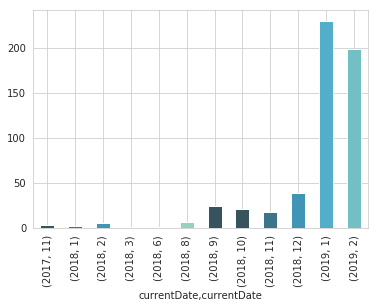

In [11]:
df_count.currentDate.groupby([df_count["currentDate"].dt.year, df_count["currentDate"].dt.month]).count().plot(kind="bar")

### Filtering only calls from jan and feb 2019 

In [12]:
# First I evaluated the number of customers in completed dataset
all_customers = df_count.customerCode.unique()

In [13]:
df_count_2019 = df_count[df_count.currentDate >= '2019-01-01']

In [14]:
# Collecting all customers in filtered dataset
filtered_customers = df_count_2019.customerCode.unique()

In [15]:
# Users that will be ignored because of filtering.
ignored_users = set(all_customers).difference(filtered_customers)

In [16]:
# including days for all filtered users in selected period. 
date = df_count_2019.currentDate.unique().tolist()
customer = df_count_2019.customerCode.unique().tolist()
df_miss_values =  pd.DataFrame(list(itertools.product(date, customer))).rename(columns={0: 'currentDate',1: 'customerCode'})
df_miss_values.currentDate = pd.to_datetime(df_miss_values.currentDate)
df_miss_values.sort_values('currentDate', inplace=True)
df_miss_values = pd.merge(df_miss_values, df_count_2019, on=['currentDate','customerCode'], how='left')
df_miss_values.head(9)

,currentDate,customerCode,sla
0,2019-01-01,372301,1.0
1,2019-01-01,215,NaN
2,2019-01-01,2581,NaN
3,2019-01-01,3363,NaN
4,2019-01-01,8068,NaN
5,2019-01-01,87520,NaN
6,2019-01-01,900995,NaN
7,2019-01-01,39159,NaN
8,2019-01-01,797391,NaN


In [17]:
# Calculate sla for these days
df_miss_values['sla'] = calculate_sla(df_miss_values, df)
df_miss_values.head(9)

,currentDate,customerCode,sla
0,2019-01-01,372301,1.0
1,2019-01-01,215,0.0
2,2019-01-01,2581,0.0
3,2019-01-01,3363,0.0
4,2019-01-01,8068,0.0
5,2019-01-01,87520,0.0
6,2019-01-01,900995,0.0
7,2019-01-01,39159,0.0
8,2019-01-01,797391,0.0


### Data Distribution

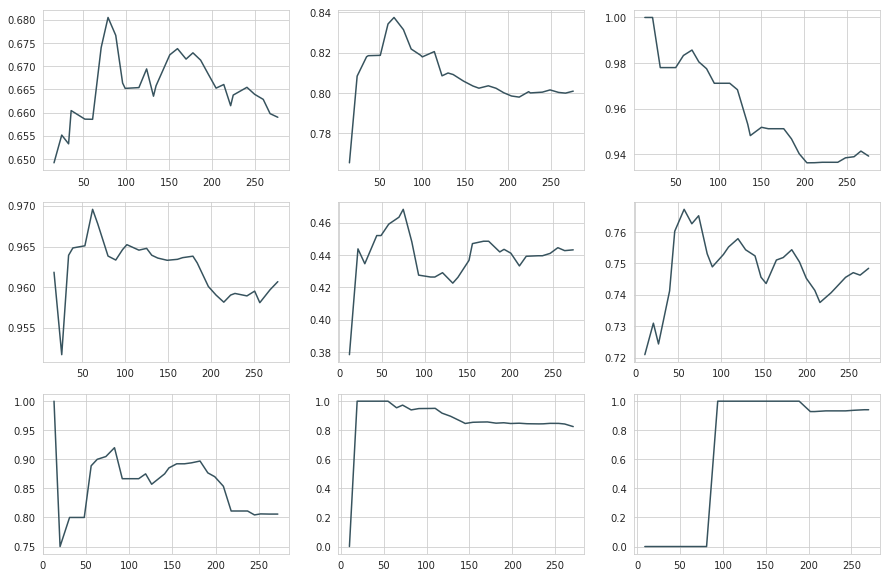

In [18]:
for i, n in enumerate(filtered_customers):
    plt.subplot(3, 3, i+1)
    jan = df_miss_values[(df_miss_values.customerCode == n) & (df_miss_values.currentDate < '2019-02-01')]
    jan.sla[1:].plot(figsize=(15, 10))

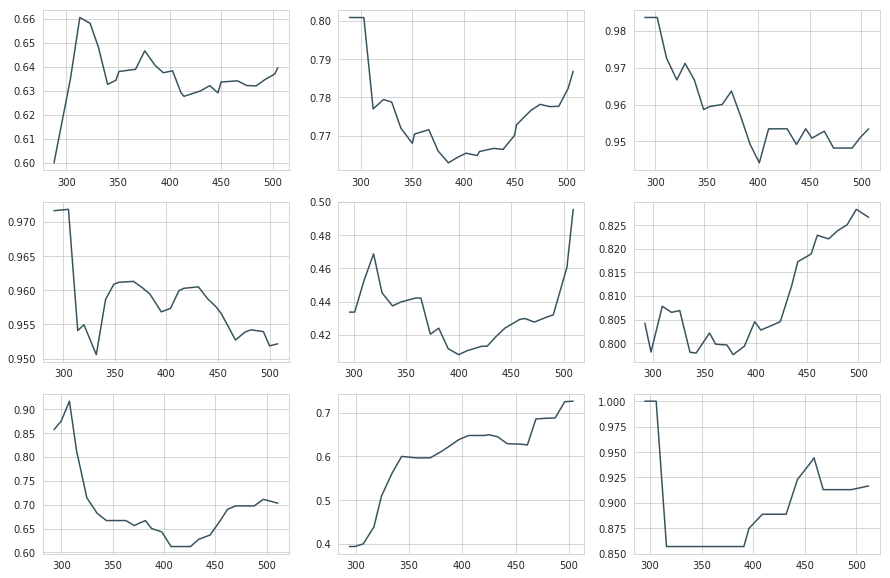

In [19]:
for i, n in enumerate(filtered_customers):
    plt.subplot(3, 3, i+1)
    feb = df_miss_values[(df_miss_values.customerCode == n) & (df_miss_values.currentDate >= '2019-02-01')]
    feb.sla[1:].plot(figsize=(15, 10))

### Understading ingnored user(s)

In [20]:
ignored_users

{900102}

In [21]:
df[df.customerCode == 900102]

,currentDate,customerCode,onTimeSolution,deadlineDateTime
11,2018-01-08,900102,1,2018-05-17 13:51:00


- This customer only appeared once, and there is not enough data to make reliable predictions.

### Write in a file

In [22]:
df_miss_values.to_csv('../dataset/ticket_cientista_processed_per_day.csv', index=False)